**Daniel Yu**

CS 252: Mathematical Data Analysis and Visualization

Spring 2024

Project 6: Supervised Learning and Handwritten Digit Recognition

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 2: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 2a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Perform min-max normalization on the train and test sets to normalize each data feature "separately".
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [5]:
def min_max_normalize(train_data, test_data):
    min_vals = np.min(train_data, axis=0)
    max_vals = np.max(train_data, axis=0)
    train_norm = (train_data - min_vals) / (max_vals - min_vals)
    test_norm = (test_data - min_vals) / (max_vals - min_vals)
    return train_norm, test_norm

# Load train and test sets
train_df = pd.read_csv("data/rbf_dev_train.csv")
test_df = pd.read_csv("data/rbf_dev_test.csv")

# Separate data variables (X) and class values (Y)
rbf_dev_train = train_df.drop(columns=['class']).values
y_train = train_df['class'].values
rbf_dev_test = test_df.drop(columns=['class']).values
y_test = test_df['class'].values

# Perform min-max normalization
rbf_dev_train, rbf_dev_test = min_max_normalize(rbf_dev_train, rbf_dev_test)

# Check the shapes of the normalized data
print("Normalized training data shape:", rbf_dev_train.shape)
print("Normalized test data shape:", rbf_dev_test.shape)

Normalized training data shape: (1600, 2)
Normalized test data shape: (400, 2)


#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [6]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [7]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


##### Check dtypes (detailed)

In [8]:
print(f'Your training set is an float? {isinstance(rbf_dev_train[0,0], float)}')
print(f'Your training classes is an int? {isinstance(y_train[0], np.int64)}')
print(f'Your test set is an float? {isinstance(rbf_dev_test[0,0], float)}')
print(f'Your test classes is an int? {isinstance(y_test[0], np.int64)}')

Your training set is an float? True
Your training classes is an int? True
Your test set is an float? True
Your test classes is an int? True


##### Check normalization (detailed)

In [9]:
print(f'Your training set mins/maxs: {rbf_dev_train.min(axis=0)}/{rbf_dev_train.max(axis=0)}\nand should be                [0. 0.]/[1. 1.]')
print(f'Your test set mins/maxs: {rbf_dev_test.min(axis=0)}/{rbf_dev_test.max(axis=0)}\nand should be            [0.02038 0.01194]/[0.99805 0.98749]')

print(f'Training values look ok? {len(np.unique(rbf_dev_train)) > 2}')
print(f'Test values look ok? {len(np.unique(rbf_dev_test)) > 2}')

Your training set mins/maxs: [0. 0.]/[1. 1.]
and should be                [0. 0.]/[1. 1.]
Your test set mins/maxs: [0.02038 0.01194]/[0.99805 0.98749]
and should be            [0.02038 0.01194]/[0.99805 0.98749]
Training values look ok? True
Test values look ok? True


### 2b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

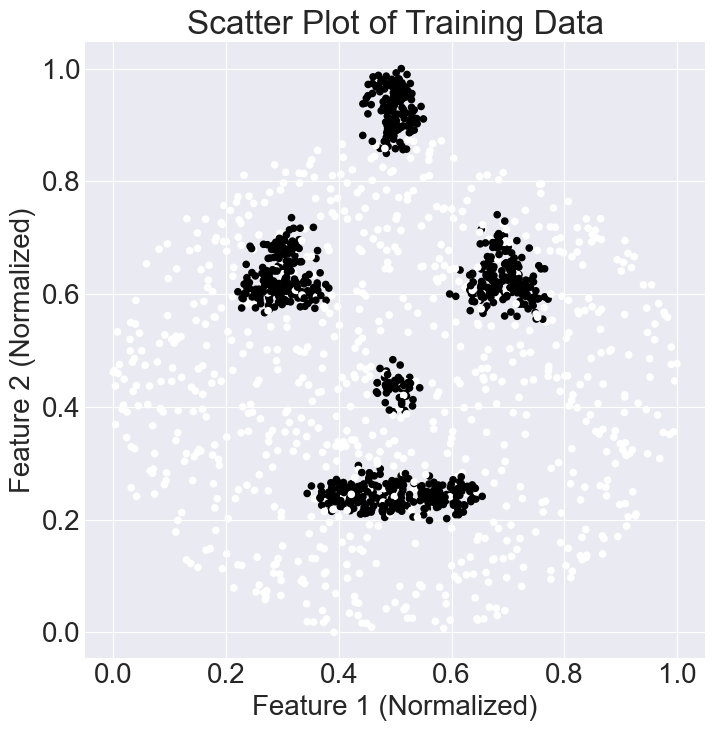

In [11]:
# Create a scatter plot of the training data
plt.figure(figsize=(8, 8))
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c=y_train, s=20)
plt.title('Scatter Plot of Training Data')
plt.xlabel('Feature 1 (Normalized)')
plt.ylabel('Feature 2 (Normalized)')
plt.axis('equal')  # Set equal aspect ratio for x and y axes
plt.show()

## Task 3: Radial basis function neural network

In [12]:
from rbf_net import RBF_Net

### 3a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [13]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [14]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [15]:
np.random.seed(0)
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

Your prototypes have shape (4, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (4,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

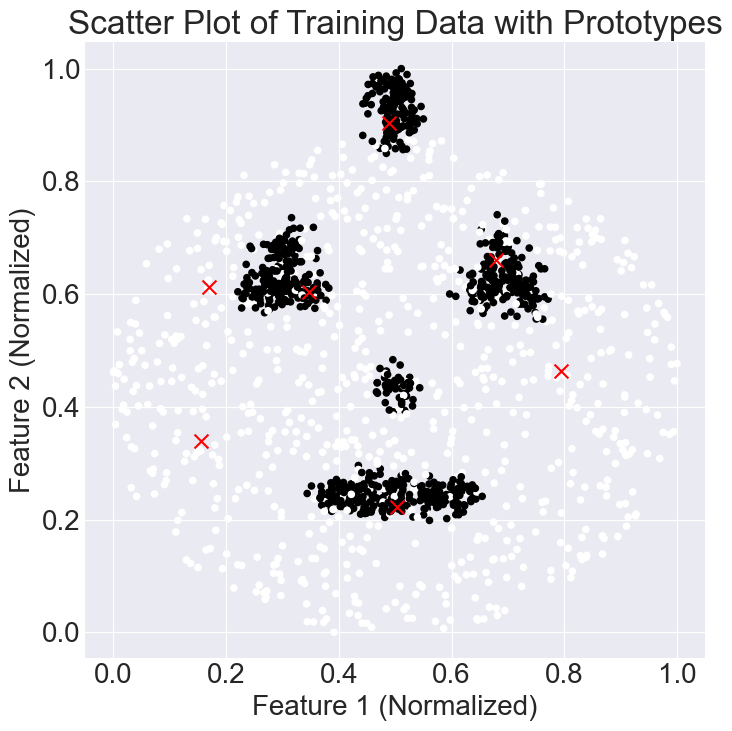

In [16]:
np.random.seed(0)
rbf_net = RBF_Net(7, 2)
rbf_net.initialize(rbf_dev_train)
prototypes = rbf_net.get_prototypes()
plt.figure(figsize=(8, 8))
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c=y_train, s=20, label='Training Data')
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='red', marker='x', s=100, label='Prototypes')
plt.title('Scatter Plot of Training Data with Prototypes')
plt.xlabel('Feature 1 (Normalized)')
plt.ylabel('Feature 2 (Normalized)')
plt.axis('equal')
plt.show()

### 3b. Questions

**Question 7:** Will the prototypes enable the RBF network to learn to classify the dataset well? Why or why not?

**Answer 7:** Somewhat? The prototypes enable the RBF network to learn the data well because by placing them at certain locations in the input space, the RBF network can make accurate predictions of the relationship between inputs and outputs.

### 3c. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [17]:
np.random.seed(1)
test_data = np.random.normal(size=(3, 5))
test_centroids = np.random.normal(size=(4, 5))

test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [18]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.79555 -0.17162  0.38867]\n [-0.79545 -0.17189  0.38875]\n [-0.79534 -0.17188  0.3888 ]]')

Your output layer activation is
[[-0.79555 -0.17162  0.38867]
 [-0.79545 -0.17189  0.38875]
 [-0.79534 -0.17188  0.3888 ]]

and should be
[[-0.79555 -0.17162  0.38867]
 [-0.79545 -0.17189  0.38875]
 [-0.79534 -0.17188  0.3888 ]]


### 3d. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

To solve for the weights/unknown coefficients, you will use implement a SVD-based linear regression solver, which is both fast and numerically accurate. In the equation $Ac = y$ The weights $c$ can be solved via the following matrix equation: $$c = A^+y$$ where $A^+$ is the pseudo inverse of the matrix of RBF hidden layer activations $A$ (*data matrix*) and the correct classes $y$.

#### If you get here before we cover the SVD-based linear regression solver in lecture:

In `rbf.py`, implement:
- `linear_regression(A, y)`. Use the Scipy solver for now: `scipy.linalg.lstsq`. Recall, this was one of your supported solvers in the Linear Regression project.

Skip over **Test: Pseudo inverse** below.

#### After we cover the SVD-based linear regression solver in lecture:

In `rbf.py`, implement:
1. `pseudo_inverse(A)`. Then run test code below.
2. `linear_regression(A, y)`. Replace `scipy.linalg.lstsq` with your own SVD-based linear regression solver.

#### Test: Pseudo inverse

In [19]:
np.random.seed(0)
test_A = np.random.rand(10, 5)
net = RBF_Net(num_classes=3, num_hidden_units=5)
test_A_plus = net.pseudo_inverse(test_A)
print(f'The mean abs error between your pseudo inverse of A and the true one is:\n{np.sum(np.abs(test_A_plus - np.linalg.pinv(test_A)))} and should be 0.0')

The mean abs error between your pseudo inverse of A and the true one is:
0.0 and should be 0.0


#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

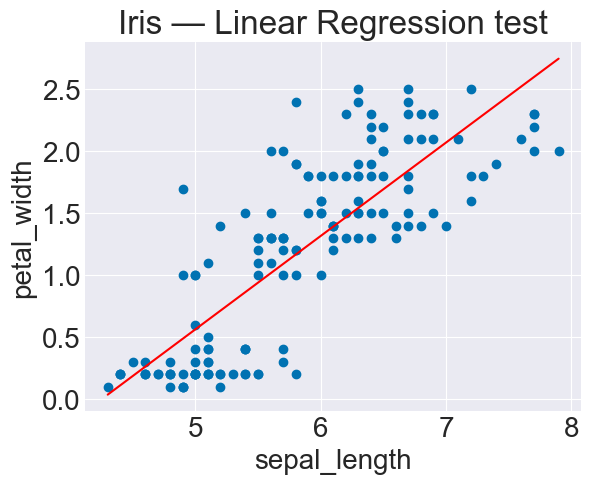

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = iris_c[0] + line_x*iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y, c='r')
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 3e. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.


In [28]:
rbf_net = RBF_Net(10,2)
rbf_net.train(rbf_dev_train, y_train)

y_train_pred = rbf_net.predict(rbf_dev_train)
y_test_pred = rbf_net.predict(rbf_dev_test)

print(rbf_net.accuracy(y_train, y_train_pred))
print(rbf_net.accuracy(y_test, y_test_pred))

0.88375
0.895


## Task 4: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 4a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

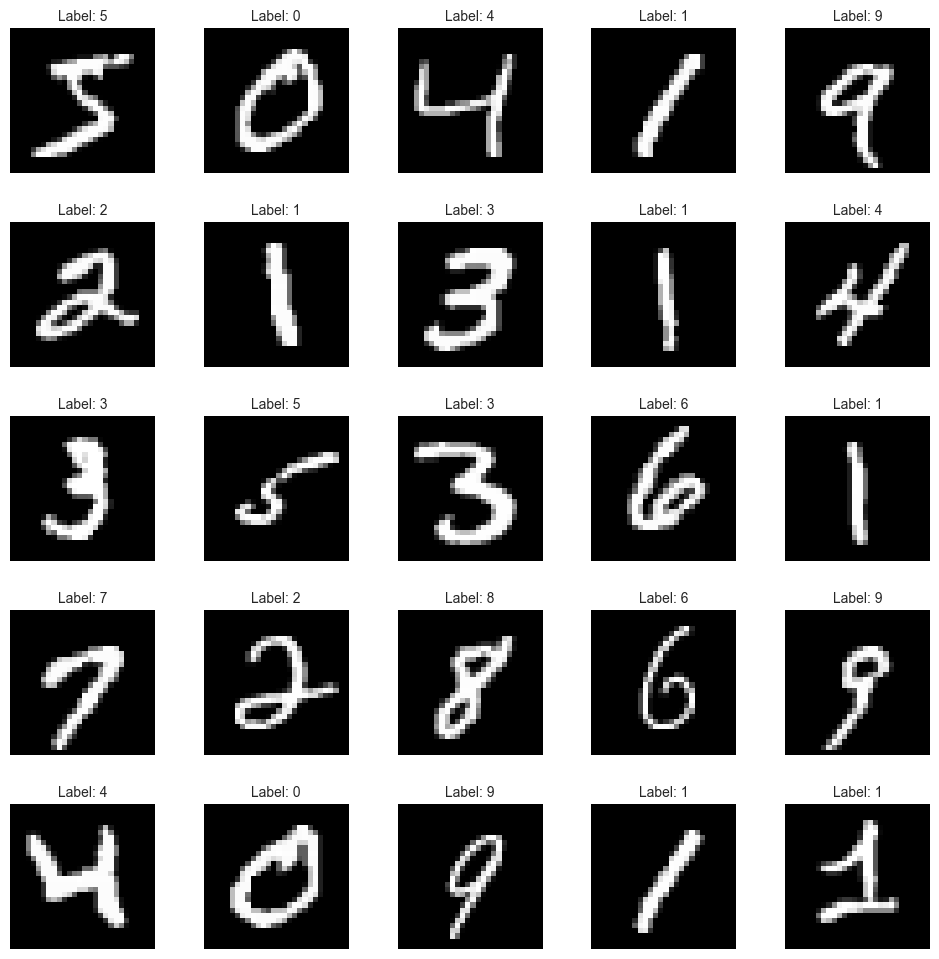

In [92]:
mnist_train_data = np.load('data/mnist_train_data.npy')
mnist_train_labels = np.load('data/mnist_train_labels.npy')
mnist_test_data = np.load('data/mnist_test_data.npy')
mnist_test_labels = np.load('data/mnist_test_labels.npy')

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        axes[i, j].imshow(mnist_train_data[idx].reshape(28, 28), cmap='gray')
        axes[i, j].set_title(f"Label: {mnist_train_labels[idx]}", fontsize=10)
        axes[i, j].axis('off')  

plt.tight_layout()
plt.show()

In [93]:
print(f'Your training set shape is {x_train.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {y_train.shape} and should be (60000,).')
print(f'Your test set shape is {x_test.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {y_test.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


### 4b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [94]:
x_train_flat = np.reshape(mnist_train_data, (mnist_train_data.shape[0], -1)) / 255
x_test_flat = np.reshape(mnist_test_data, (mnist_test_data.shape[0], -1)) / 255
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


### 4c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~3000) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [95]:
mnist_net = RBF_Net(160, 10)
mnist_net.train(x_train_flat[:3000], y_train[:3000])
y_pred_train = mnist_net.predict(x_train_flat[:3000])
y_pred_test = mnist_net.predict(x_test_flat)
# train acc
print(mnist_net.accuracy(y_train[:3000], y_pred_train))
# test acc
print(mnist_net.accuracy(y_test, y_pred_test))
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

0.9356666666666666
0.912


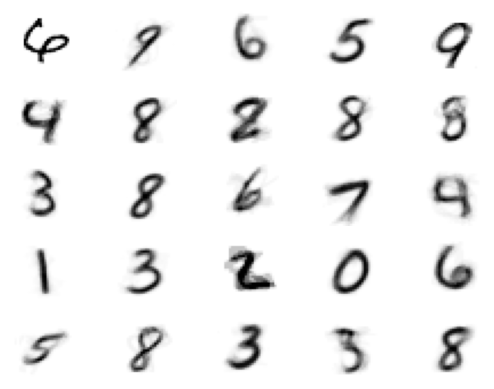

In [51]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

### 4d. Questions

**Question 8:** Which part of the training process takes the longest?

**Question 9:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Question 10:** Using the same parameters to get the training accuracy that you reported in Question 3, what test accuracy did you achieve?

**Answer 8:** Train. We generate 160 prototypes by running KMeans++ clustering algorithim that results in being computationally intensive and causing the trainign process to.

**Answer 9:** The accuracy I achieved on the training set is 93.34%, where I used 3000 training samples, 10 output units, and 160 hidden units in network.

**Answer 10:** 91%.

### 4e. Visualize prototypes using network weights

Now that you've trained the network to recognize handwritten digits, let's visualize the dominant factors that the network learns to rely on to make each prediction.

Create a 10 x 5 plot showing images of the 5 "most influential hidden layer prototypes" that contribute to predicting each of the 10 output classes. These are defined as the hidden layer prototypes that have the 5 largest weights (in absolute value) going from the hidden layer to the output layer. *Recall that each hidden unit prototype has the same shape as a single data sample so each image in your grid should be 28x28.*

**Note:** We want to remove/ignore the weight for bias neuron from this analysis.

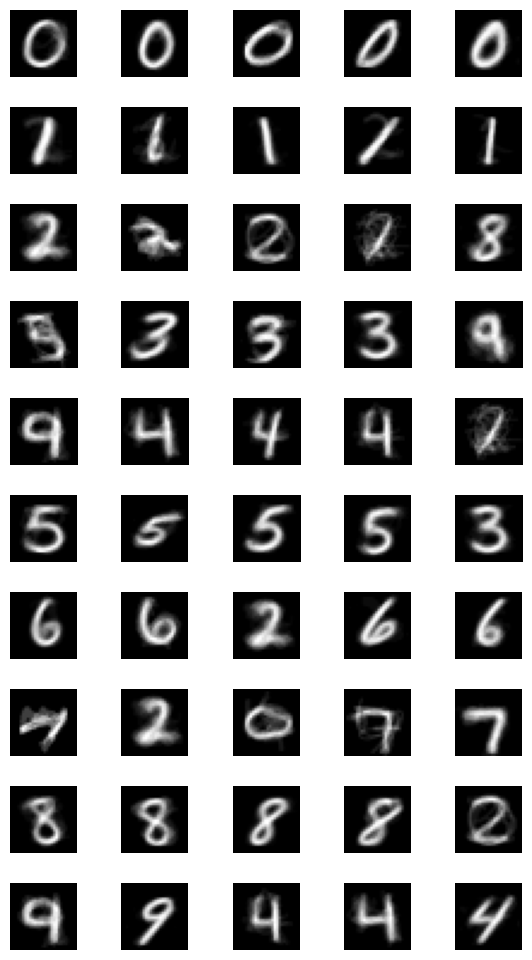

In [34]:
wts_hidden_output = mnist_net.wts[1:, :]
prototypes = 5
prototype_indices = np.zeros((10, prototypes), dtype=int)
for i in range(10):
    # Inds: among top ones, least (left) -> most (right)
    inds = np.argsort(np.abs(wts_hidden_output[:, i]))[-prototypes:]
    # Make it most to least
    prototype_indices[i, :] = inds[::-1]

fig, ax = plt.subplots(10, prototypes, figsize=(10, 10))
plt.subplots_adjust(wspace=-0.9, hspace=-0.5)
for i in range(10):
    for j in range(prototypes):
        ax[i, j].imshow(mnist_net.prototypes[prototype_indices[i, j], :].reshape(28, 28), cmap='gray')
        ax[i, j].set_axis_off()
plt.tight_layout()
plt.show()

### 4f. Questions

**Question 11:** Interpret what each row of your 10x5 grid of images means. Did any of the top prototypes surprise you?

**Answer 11:** Each row of the 10x5 grid represents one of the ten output classes, such that each column represents one of the five most influential hidden layer prototypes. Regarding any surprises for the top prototypes, seems like the number 0 is considered one of the most influential hidden layer prototype, as it appeared in multiple rows with the plot above. Additionally, this means that 0 as a prototype, has the largest weight.

## Task 5: Comparison between RBF Neural Network and KNN on MNIST

The goal of this task is to compare the classification results produced by your RBF neural network and KNN classifiers.

In [35]:
from knn import KNN

### 5a. Accuracy comparison

In the 1st cell below:
- train your KNN classifier with K=1 (i.e. nearest neighbor) on the MNIST training set.
- Print out the accuracy achieved by KNN on the first 500 samples of the test set.

In the 2nd cell below:
- Print out the accuracy achieved by your RBF neural network (that you trained above) on the first 500 samples of the test set.

In [84]:
knn_classifier = KNN(num_classes=10)
knn_classifier.train(x_train_flat, y_train)
k = 1
y_test_pred_knn = knn_classifier.predict(x_test_flat[:500], k)
accuracy_knn = knn_classifier.accuracy(mnist_test_labels[:500], y_test_pred_knn)
print(f"Accuracy achieved by KNN with K=1 on the first 500 samples of the test set: {accuracy_knn:%}")

Accuracy achieved by KNN with K=1 on the first 500 samples of the test set: 96.600000%


In [96]:
y_test_pred_mnist_net = mnist_net.predict(x_test_flat[:500])
accuracy_mnist_net = mnist_net.accuracy(mnist_test_labels[:500], y_test_pred_mnist_net)
print(f"Accuracy achieved by the RBF neural network on the first 500 samples of the test set: {accuracy_mnist_net:%}")

Accuracy achieved by the RBF neural network on the first 500 samples of the test set: 90.400000%


In [97]:
y_test_pred_knn = knn_classifier.predict(x_test_flat[:1000], k)
accuracy_knn = knn_classifier.accuracy(mnist_test_labels[:1000], y_test_pred_knn)
print(f"Accuracy achieved by KNN with K=1 on the first 1000 samples of the test set: {accuracy_knn:%}")
y_test_pred_mnist_net = mnist_net.predict(x_test_flat[:1000])
accuracy_mnist_net = mnist_net.accuracy(mnist_test_labels[:1000], y_test_pred_mnist_net)
print(f"Accuracy achieved by the RBF neural network on the first 1000 samples of the test set: {accuracy_mnist_net:%}")

Accuracy achieved by KNN with K=1 on the first 1000 samples of the test set: 96.200000%
Accuracy achieved by the RBF neural network on the first 1000 samples of the test set: 88.800000%


### 5b. Questions

**Question 12:** What two things jump out to you about the two supervised learning models? (*Hint: Try increasing the number of test samples to 1000 or 2000*).

**Answer 12:**  The KNN classifier with K=1 achieves a higher accuracy compared to the RBF neural network on the first 500 and 1000 samples of the test set. This suggests that for this particular task and dataset, the KNN model is more effective at making predictions than the RBF neural network. Both models also retain a high level of accuracy, as they have similar accuracies between 500 and 1000 samples..

### 5c. Implement confusion matrix

Implement the `confusion_matrix` method in the `Classifer` class then test it below.

#### Test confusion matrix

In [56]:
from classifier import Classifier

In [57]:
num_test_classes = 4
np.random.seed(0)
y_true_cf = np.random.randint(low=0, high=num_test_classes, size=(100,))
y_test_cf = np.random.randint(low=0, high=num_test_classes, size=(100,))

test_classifier = Classifier(num_classes=num_test_classes)
test_cm = test_classifier.confusion_matrix(y_true_cf, y_test_cf)

print(f'Your confusion matrix is:\n{test_cm} and it should be:')
print('''[[ 8.  3.  6.  8.]
 [ 5.  5. 10.  4.]
 [ 3.  3.  7.  6.]
 [10.  7.  6.  9.]]''')

Your confusion matrix is:
[[ 8.  3.  6.  8.]
 [ 5.  5. 10.  4.]
 [ 3.  3.  7.  6.]
 [10.  7.  6.  9.]] and it should be:
[[ 8.  3.  6.  8.]
 [ 5.  5. 10.  4.]
 [ 3.  3.  7.  6.]
 [10.  7.  6.  9.]]


### 5d. Inspect misclassifications

To better understand the misclassifications made by the two classifiers, in the cell below print out a confusion matrix for each classifier based on the 1st 500 test set samples.

*Optional:* If you like, you can visualize the confusion matrix with a heatmap. I would suggest superimposing the confusion matrix values on the heatmap so you see not only the color but the numeric count at each location.

In [101]:
y_test_pred_knn = knn_classifier.predict(x_test_flat[:500], k)
conf_matrix_knn = knn_classifier.confusion_matrix(y_test[:500], y_test_pred_knn)
y_test_pred_mnist_net = mnist_net.predict(x_test_flat[:500])
conf_matrix_rbf = mnist_net.confusion_matrix(y_test[:500], y_test_pred_mnist_net)

Confusion Matrix for KNN Classifier:
[[42.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 67.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 53.  0.  0.  0.  0.  1.  1.  0.]
 [ 0.  0.  0. 42.  0.  1.  0.  2.  0.  0.]
 [ 0.  1.  0.  0. 52.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  1.  0. 49.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0. 41.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0. 48.  0.  0.]
 [ 1.  0.  0.  0.  0.  1.  0.  0. 38.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  1.  1. 51.]]


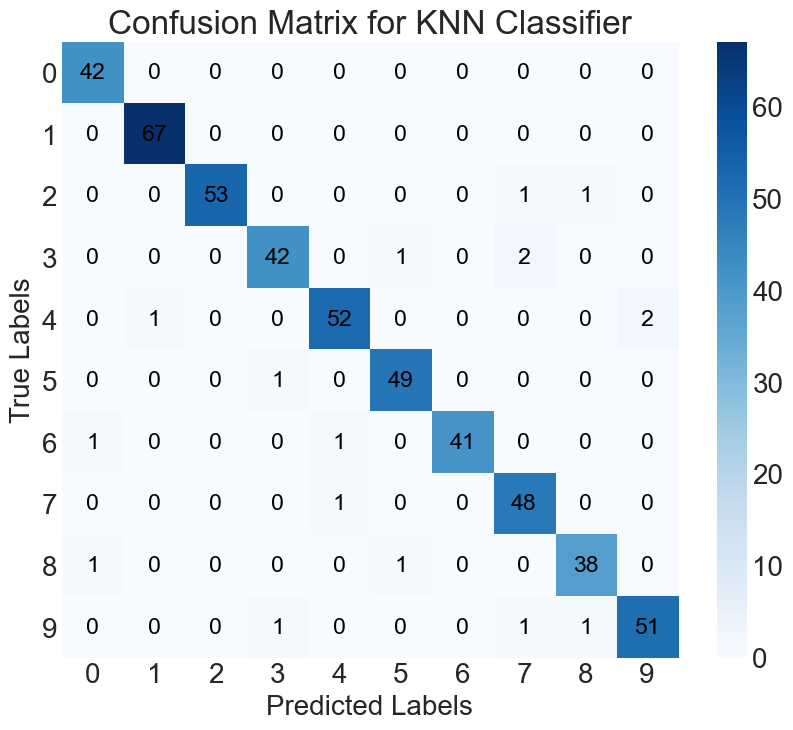


Confusion Matrix for RBF Neural Network:
[[42.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 67.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. 48.  1.  0.  0.  0.  3.  1.  1.]
 [ 0.  0.  3. 37.  0.  1.  1.  3.  0.  0.]
 [ 1.  0.  0.  0. 50.  0.  2.  0.  0.  2.]
 [ 1.  0.  0.  2.  0. 47.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  1.  1. 39.  0.  0.  0.]
 [ 0.  0.  1.  0.  3.  0.  0. 44.  0.  1.]
 [ 2.  0.  0.  0.  0.  2.  1.  2. 32.  1.]
 [ 0.  0.  0.  0.  3.  0.  0.  2.  3. 46.]]


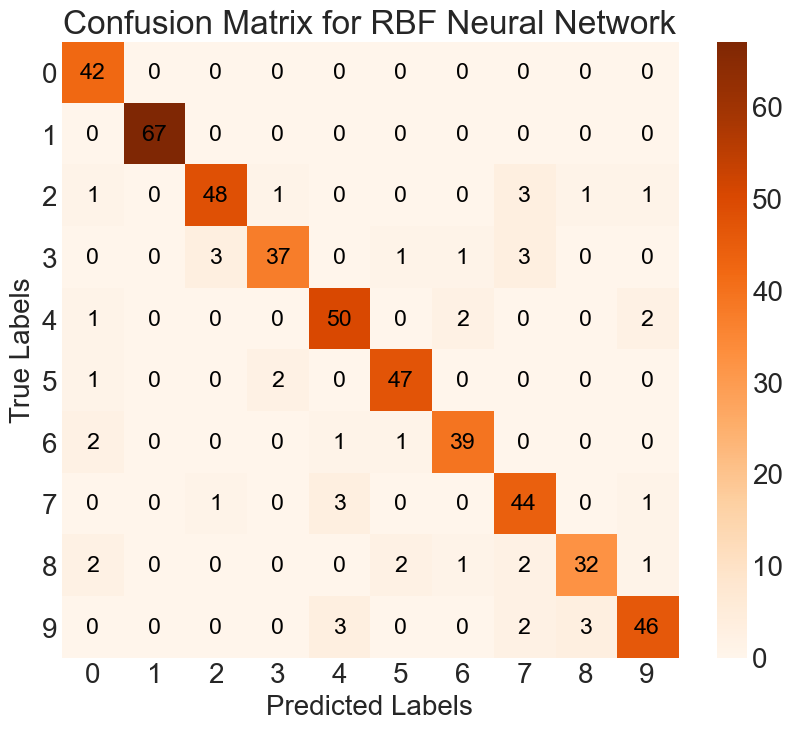

In [102]:
print("Confusion Matrix for KNN Classifier:")
print(conf_matrix_knn)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_knn, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(np.arange(0, 10))
plt.yticks(np.arange(0, 10))
plt.grid(False)
plt.title("Confusion Matrix for KNN Classifier")
for i in range(len(conf_matrix_knn[0])):
    for j in range(len(conf_matrix_knn[0])):
        plt.text(j, i, int(conf_matrix_knn[i, j]),
                       ha="center", va="center", color="black",size="small")
plt.colorbar()
plt.show()

print("\nConfusion Matrix for RBF Neural Network:")
print(conf_matrix_rbf)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_rbf, cmap="Oranges")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(np.arange(0, 10))
plt.yticks(np.arange(0, 10))
plt.grid(False)
plt.title("Confusion Matrix for RBF Neural Network")
for i in range(len(conf_matrix_rbf[0])):
    for j in range(len(conf_matrix_rbf[0])):
        plt.text(j, i, int(conf_matrix_rbf[i, j]),
                       ha="center", va="center", color="black",size="small")
plt.colorbar()
plt.show()

### 5e. Questions

**Question 13:** Identify specific cases among the most common confusions that each classifier makes. Why do they make sense or do not make sense to you?

**Answer 13:** KNN: 2 samples of digit 4 are misclassified as digit 9, and 2 samples of digit 9  are misclassified as digit 4. This makes sense for the most part, as they both follow a circle with a thing dangling from the bottom, the only difference being a 4 is a lot more sharper, but that may be different depending on the handwriting style. There is also 1 sample of digit 3 misclassified as digit 8 and 1 sample of digit 8 misclassified as digit 3, which sort of makes sense, since 3 is like half of 8 so I can see the resemblence. Some styles may make the gap a lot less obvious.

RBF:
There is confusion between digits 2 and 7, with 4 samples of digit 2 misclassified as digit 7, which doesn't make that much sense, because 2 has a whole other stroke to it which I think would make it more recognizable, though it is the closest thing as all the other numbers have less or more strokes. Just like KNN, the network also shows confusion between digits 4 and 9, with 2 sample of digit 4 misclassified as digit 9 and 4 samples of digit 9 misclassified as digit 4. Again, this confusion arises from the visual similarities between these digits.its.

## Extensions

### a. Reminder: AI Policy

The goal of extensions is to learn and create something new beyond the base project that excites you. To serve this goal and out of fairness to your hardworking classmates, **AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions.** This includes both written analysis, plotting, and code. We will only grade **your** work, not an AI's. **We will stop grading your project if we notice AI-generated content (to any capacity).**

### b. Guidelines

To receive credit for any extension, you must:
1. Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
2. **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
3. Include (*labeled!*) plots and/or numbers to present your results.
4. Write up your extensions below or in a separate notebook.
5. Give kudos to all sources, including anyone that you consulted.

### c. Suggestions

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

The ideas below are **suggested** extensions — feel free to go in another direction related to this project that is not listed!

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

### 2) Visualize network predictions

Make visualizations to show and interpret the MNIST network predictions. Lots of possibilities, here are a few specific ideas:
- Make show a grid of test samples labeled with their predicted digit.
- Analyze if the network performance favors accuracy for certain digits and not others.
- Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).
- Make and interpret a confusion plot.

### 3) Explore parameter space

When training your RBF network on MNIST, you had to pick some parameter values to use by hand. Pick one or more parameters and systematically vary them to quantify their effect on accuracy and simulation time.

### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

### 5) Other datasets

Use your RBF network to classify other datasets.

### 6) Analyze the trained network

Run simulations then analyze and interpret the results. Here are some ideas:
- Visualize and analyze how the prototypes influence the classification results.
- Visualize and analyze how the network weights influence the classification results.

## Part 1: Visualizing Network Predictions

Because it's cool to use matplotlib.

### - Make show a grid of test samples labeled with their predicted digit.

I'll be reusuing some of my earlier code to print the labels to do this.

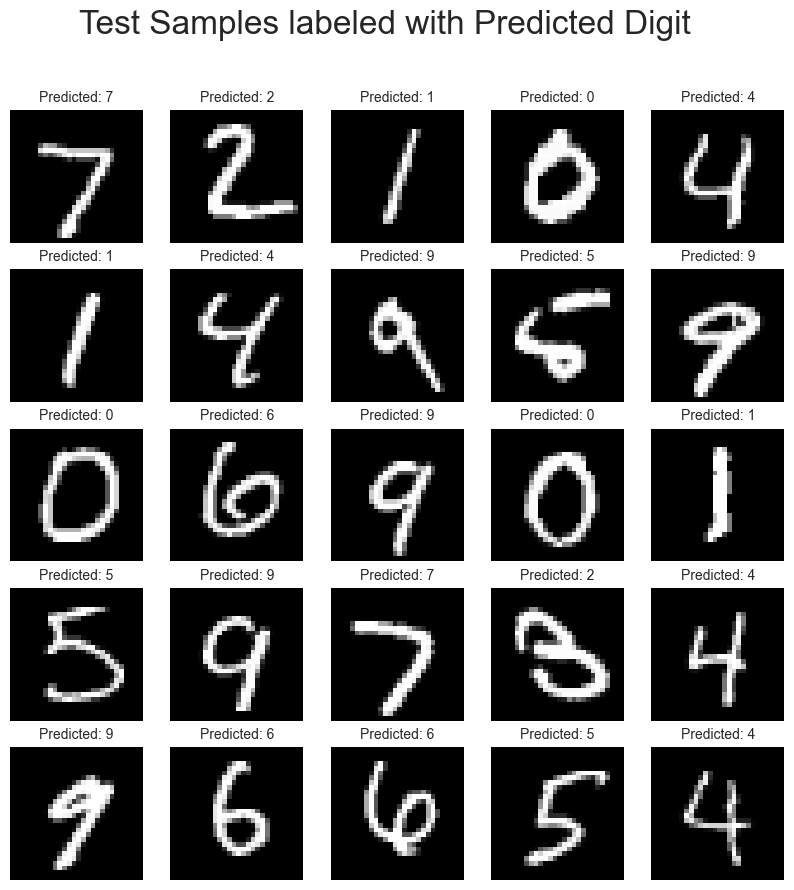

In [103]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Test Samples labeled with Predicted Digit")
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        axs[i, j].imshow(x_test_flat[idx].reshape(28, 28), cmap='gray')
        axs[i, j].set_title(f"Predicted: {str(y_pred_test[idx])}", fontsize=10)
        axs[i, j].axis('off') 

plt.show()

### - Make and interpret a confusion plot + Analyze if the network performance favors accuracy for certain digits and not others.

I decided to try to make a new way of visualizing the accuracy from the confusion matrix. From the confusion matrix, I could then create a bar graph that demonstrated the classification accuracy for each digit.Thise bar grap shows that, all the digits had similar numbers in terms of accuracies,so generally  all the numbers in the MNISTaree represented equally. This then means that the network does not favor accuracy for certain digits, but also could mean that the network is not good at recongizing all the digits in the inputted data.

We have to acknowledged that this was constructed from a sample base thatd does not include all the samples in the inputted data, since the training data is too large (and would result in taking too long to process), such that the plot does not accurately demonstrate thegeneeral  accuracy of the digits. Therefore, it is possible that the inputted data does favor certain numbers but because we only did a portion of the data, all the numbers are distributed equally in terms of accuracy.

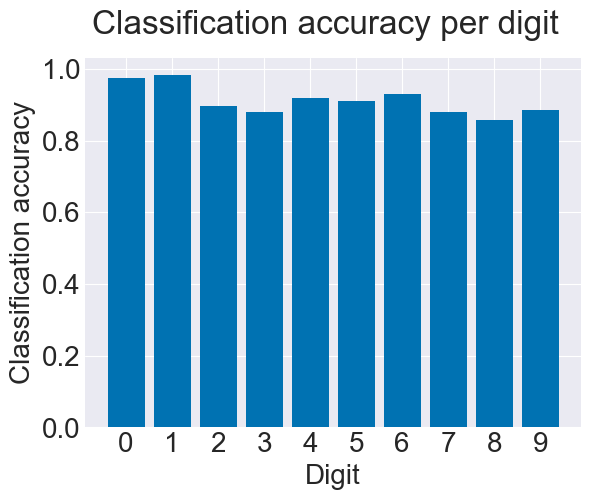

In [104]:
test_classifier = Classifier(num_classes=10)
conf_mat = test_classifier.confusion_matrix(y_test, y_pred_test)

acc_per_digit = np.diag(conf_mat) / np.sum(conf_mat, axis=1)

fig, ax = plt.subplots()
fig.suptitle("Classification accuracy per digit")
ax.bar(np.arange(10), acc_per_digit)
ax.set_xticks(np.arange(10))
ax.set_xlabel("Digit")
ax.set_ylabel("Classification accuracy")
plt.show()

### - Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).

As for this, most of what has been said has been said when I made the confusion matrix, but it doesn't seem like there are correlation betwen classes. At least for KNN, which makes a minimal amount of error, which is good, that's what we want. Problem is, all the errors made are from a single (or double) sample and its completely random, it doesn't look like there can be a digit similarity that would explains some of these. Like 7 predicted as 4? That's just sad. RBF makes more mistakes, but it looks to be also random ish, 4 and 9 can be be understandable, but there are also 2 samples predicted as 4...

## Part 2: Parameter Space

An excuse to mess with numbers.

For my last extension, I decided to train my RBF network and then determine how certain parameters quantify the effect on accuracy and simulation time. In this case, I tested when hidden units stayed kept constant, keeping it at 40 units and then varying the output units from 5 to 20, as well as vice-versa where output units were kept at 10, and then hidden units varied from 20 to 70.

In [105]:
import time

#### 20 Hidden Units, 10 Classes

In [106]:
start_time = time.time()
mnist_net = RBF_Net(20, 10)
mnist_net.train(x_train_flat[:1600], y_train[:1600])
y_pred_train = mnist_net.predict(x_train_flat[:1600])
y_pred_test = mnist_net.predict(x_test_flat)
end_time = time.time()
final = end_time - start_time

In [107]:
print(mnist_net.accuracy(y_train[:1600], y_pred_train))
print("Runtime:", final)

0.78125
Runtime: 6.647807836532593


#### 70 Hidden Units, 10 Classes

In [108]:
start_time = time.time()
mnist_net = RBF_Net(70, 10)
mnist_net.train(x_train_flat[:1600], y_train[:1600])
y_pred_train = mnist_net.predict(x_train_flat[:1600])
y_pred_test = mnist_net.predict(x_test_flat)
end_time = time.time()
final = end_time - start_time

In [109]:
print(mnist_net.accuracy(y_train[:1600], y_pred_train))
print("Runtime:", final)

0.894375
Runtime: 17.647768020629883


#### 40 Hidden Units, 5 Classes

In [110]:
start_time = time.time()
mnist_net = RBF_Net(40, 5)
mnist_net.train(x_train_flat[:1600], y_train[:1600])
y_pred_train = mnist_net.predict(x_train_flat[:1600])
y_pred_test = mnist_net.predict(x_test_flat)
end_time = time.time()
final = end_time - start_time

In [111]:
print(mnist_net.accuracy(y_train[:1600], y_pred_train))
print("Runtime:", final)

0.47125
Runtime: 11.417988300323486


#### 40 Hidden Units, 20 Classes

In [112]:
start_time = time.time()
mnist_net = RBF_Net(40, 20)
mnist_net.train(x_train_flat[:1600], y_train[:1600])
y_pred_train = mnist_net.predict(x_train_flat[:1600])
y_pred_test = mnist_net.predict(x_test_flat)
end_time = time.time()
final = end_time - start_time

In [113]:
print(mnist_net.accuracy(y_train[:1600], y_pred_train))
print("Runtime:", final)

0.83
Runtime: 12.605647563934326


When there existed more hidden units, the accuracy went from 79% to 89%. Which makes sense, when there is an increase in hidden units, it helps to increase the representational of the model, allowing more complex features to be captured. Additionally, the more output units there exists, the better the accuracy. Data is better represented by capturing more complex details. Regarding simulation time, time is more affected by the number of hidden units, as when there is an increase in the number of hidden units, the more time it takes the simulation to run. As always with all these algorithms, we find that the more information we put into our machines the more time it takes to run, but there is a trade off with a better accuracy.

### Finale: PCA

Let's bring it back so we can reduce runtime, for comparison, here's what the previous runtime was:

In [190]:
start_time = time.time()
mnist_net = RBF_Net(160, 10)
mnist_net.train(x_train_flat[:3000], y_train[:3000])
y_pred_train = mnist_net.predict(x_train_flat[:3000])
end_time = time.time()

print(mnist_net.accuracy(y_train[:3000], y_pred_train))
final = end_time - start_time
print("Runtime:", final)

0.9366666666666666
Runtime: 60.69601345062256


Now we need to see how many PCs keep the most amount of cumulative proportion, our threshold being 90%.

In [115]:
from pca import PCA

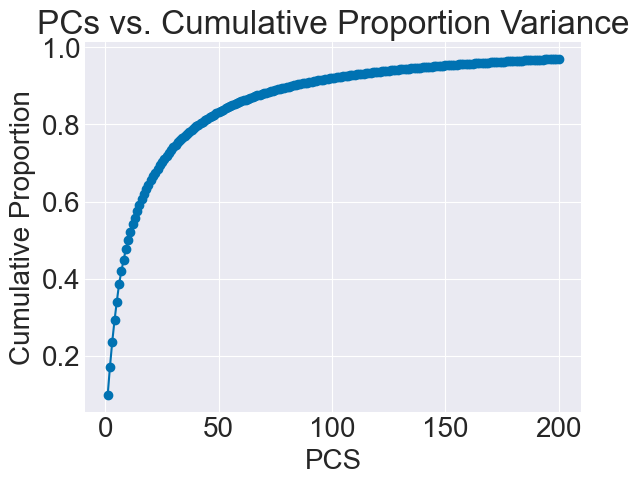

In [180]:
mnist_train_data_df = pd.DataFrame(x_train_flat[:3000], columns = range(784))
pca = PCA(mnist_train_data_df)
pca.fit(np.arange(0,784)) 
pca.elbow_plot(200)
plt.show()

We can make a rough estimation that we retain 90% Cumulative Proportion with around 100 PCs, so let's see how that looks when we project it!

(3000, 100)


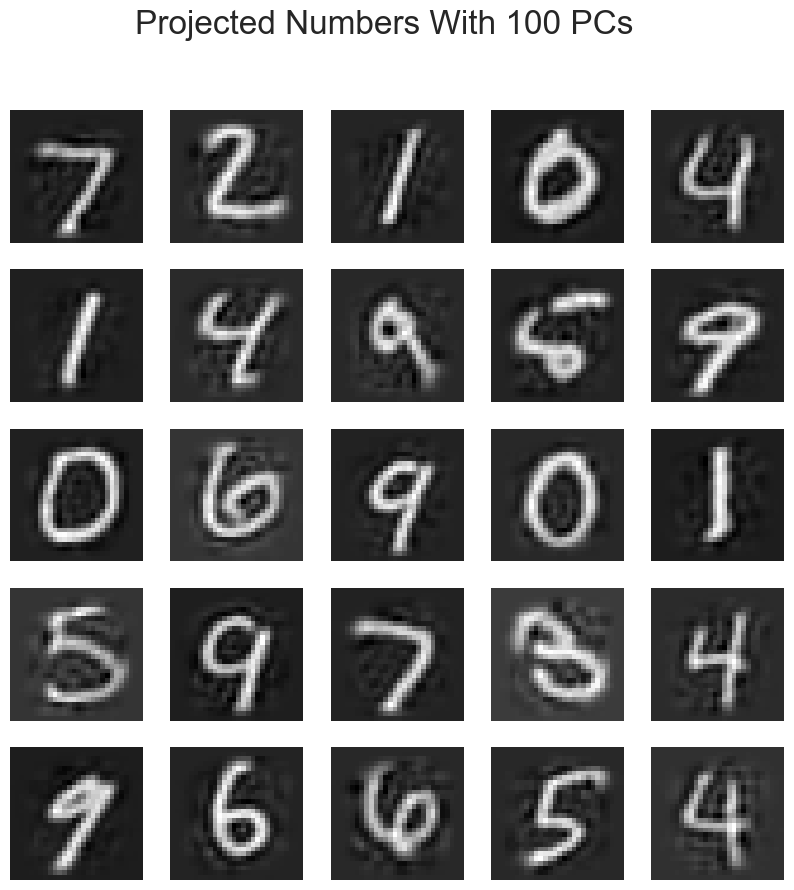

In [187]:
# Keep 100 PCs of the Training Set
P = pca.e_vecs[:,:100]
A_centered = pca.A - np.mean(pca.A, axis = 0)
TrainedPCA = A_centered @ P

# Project Eigenvectors onto Test Space
target_vec = x_test_flat
A_centered = target_vec - np.mean(target_vec, axis = 0)
pca_proj = A_centered @ P

projected_target = pca_proj @ P.T + np.mean(pca.A, axis = 0)
projected_target = np.reshape(projected_target, [x_test_flat.shape[0], 28, 28])
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Projected Numbers With 100 PCs")
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        axs[i, j].imshow(projected_target[idx].reshape(28, 28), cmap='gray')
        # axs[i, j].set_title(f"Predicted: {str(y_pred_test[idx])}", fontsize=10)
        axs[i, j].axis('off') 

plt.show()

Finally, we can run it through RBF and check the new runtime!

In [188]:
start_time = time.time()
mnist_net = RBF_Net(160, 10)
mnist_net.train(TrainedPCA[:3000], y_train[:3000])
y_pred_test = mnist_net.predict(pca_proj[:3000])
end_time = time.time()

print(mnist_net.accuracy(y_test[:3000], y_pred_test))
final = end_time - start_time
print("Runtime:", final)

0.8823333333333333
Runtime: 48.44460940361023


Our runtime was drastically decreased, but we lost a little bit of accuracy, which is a somewhat good tradeoff, but it's to be expected because we've lost a good amount of data.

### Small experiment: Centering based on training instead of itself

In [191]:
target_vec = x_test_flat
A_centered = target_vec - np.mean(pca.A, axis = 0)
pca_proj = A_centered @ P

start_time = time.time()
mnist_net = RBF_Net(160, 10)
mnist_net.train(TrainedPCA[:3000], y_train[:3000])
y_pred_test = mnist_net.predict(pca_proj[:3000])
end_time = time.time()

print(mnist_net.accuracy(y_test[:3000], y_pred_test))
final = end_time - start_time
print("Runtime:", final)

0.892
Runtime: 46.26770281791687


## KUDOS

Professor Layton as always helped troubleshoot!